# Tensorflow for Image Classification

Code referenced: [ZALCODE](https://www.kaggle.com/code/zalcode/super-simple-butterfly-image-classification#Project-Description)

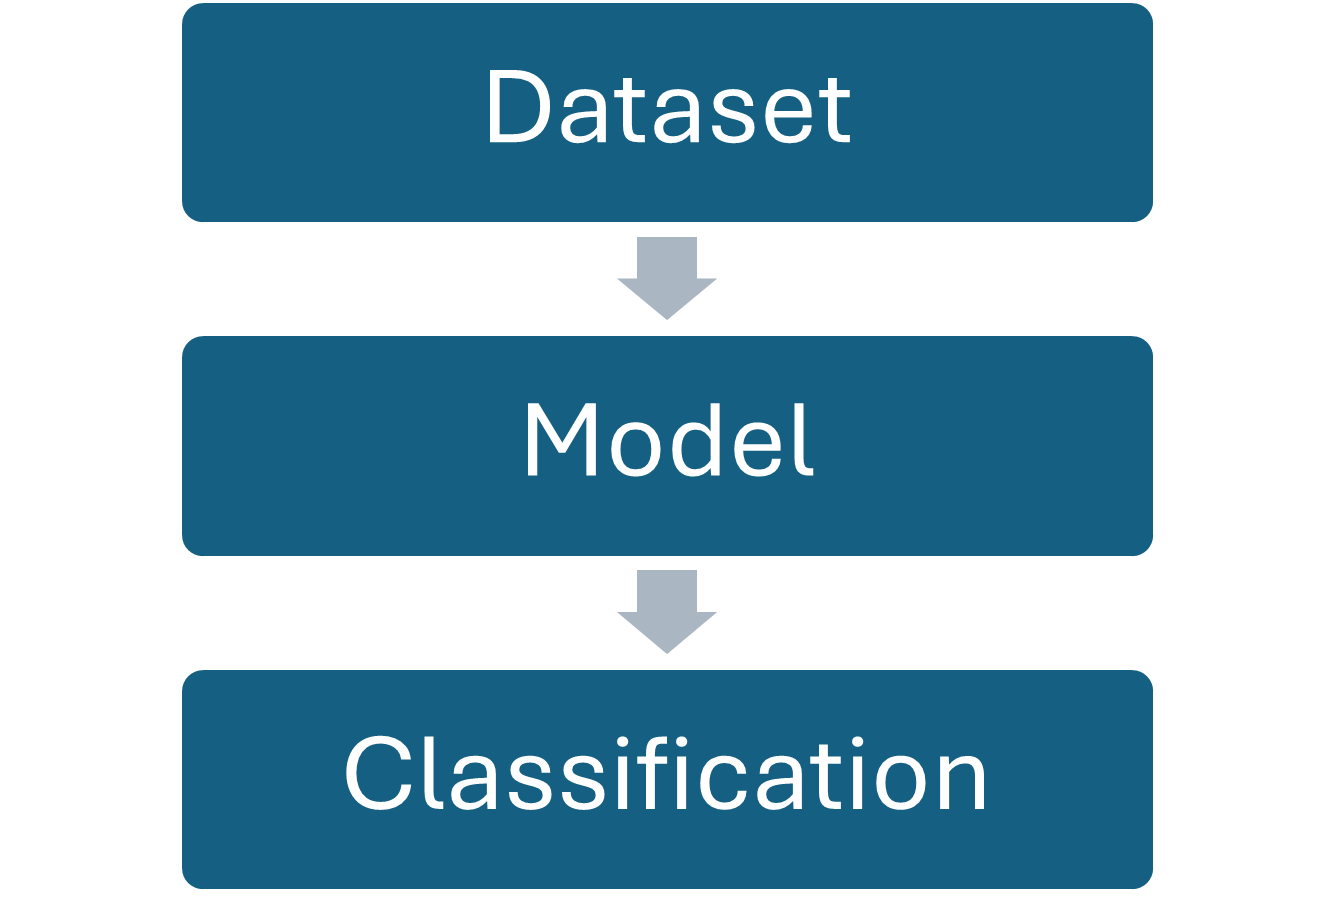 

Summary: Make Image Classification from Tensorflow's Model to classify between achiral and chiral molecules.

In [1]:
# pip install tensorflow

## Import modules

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# 1) Dataset

## Import and View Dataset

In [7]:
import pandas as pd

df_molecules = pd.read_csv("C:/Users/journ/Desktop/sandbox/Tf_molecules_6_24/tf_classify_6_25.csv")
df_molecules

,file_name,label
0,image_1.PNG,achiral
1,image_2.PNG,achiral
2,image_3.PNG,chiral
3,image_4.PNG,chiral
4,image_5.PNG,chiral
5,image_6.PNG,achiral
6,image_7.PNG,achiral
7,image_8.PNG,achiral
8,image_9.PNG,chiral
9,image_10.PNG,achiral


In [8]:
df_molecules['path'] = 'C:/Users/journ/Desktop/sandbox/Tf_molecules_6_24/train/' + df_molecules['file_name']
df_molecules

,file_name,label,path
0,image_1.PNG,achiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
1,image_2.PNG,achiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
2,image_3.PNG,chiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
3,image_4.PNG,chiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
4,image_5.PNG,chiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
5,image_6.PNG,achiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
6,image_7.PNG,achiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
7,image_8.PNG,achiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
8,image_9.PNG,chiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...
9,image_10.PNG,achiral,C:/Users/journ/Desktop/sandbox/Tf_molecules_6_...


In [9]:
df_molecules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  10 non-null     object
 1   label      10 non-null     object
 2   path       10 non-null     object
dtypes: object(3)
memory usage: 368.0+ bytes


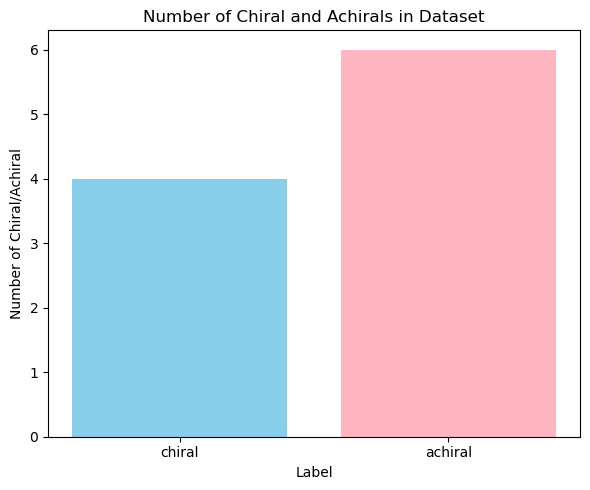

In [16]:
# Although I already know the dataset, it is good practice to see distribution of items per classificaiton

# Assuming the first column contains the labels (good or bad)
labels = df_molecules.iloc[:, 1]

# Count the number of "good" and "bad" fruits
n_chiral = (labels == "chiral").sum()
n_achiral = (labels == "achiral").sum()

# Create a list for categories
categories = ["chiral", "achiral"]

# Create a list for counts
counts = [n_chiral, n_achiral]

# Create the bar chart
plt.figure(figsize=(6, 5)) 
plt.bar(categories, counts, color=['skyblue', 'lightpink'])  
plt.xlabel("Label")
plt.ylabel("Number of Chiral/Achiral")
plt.title("Number of Chiral and Achirals in Dataset")
plt.xticks(rotation=0)  
plt.tight_layout()


plt.show()

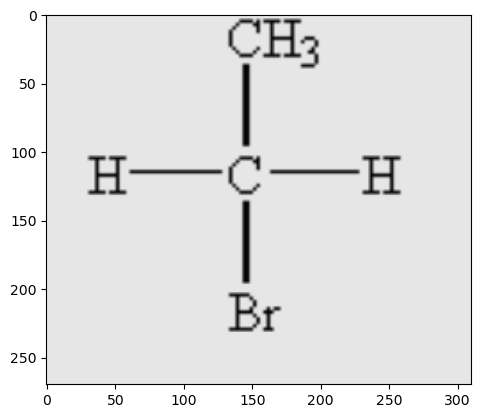

In [17]:
#show first image
from tensorflow.keras.preprocessing import image

myImage = image.load_img(r"C:/Users/journ/Desktop/sandbox/Tf_molecules_6_24/train/image_1.PNG")
plt.imshow(myImage)

## Split csv Dataset Train-Test

80:20 is default. This means 80% of the total datapoints is used to teach the model which belongs in what and 20% of the dataset not including the used 80% is used to test how well the model can classify each image to their labels.

In this case, 50:50 will be used to determine how well the model performs under such unideal conditions.

In [18]:
from sklearn.model_selection import train_test_split

train_data, validation_data = train_test_split(df_molecules, test_size=0.5, random_state=42)
print("50:50 split used.")

50:50 split used.


## Function for Data Preparation

Rescale 1/255 -> allows CNN to process images pixels on scale 0 - 1

Batch_size -> how many items to bunch together when running it through model for training
* I chose 1 to test how accurate the model would predict images labels since this learns images one by one. However, this utilizes a high level of computational cost.

class_mode -> how to label the images (binary 0/1 or as strings)

In [53]:
def prep_data(train_data, validation_data, batch_size=1):
    # Create ImageDataGenerator for training set
    train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    train_set = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col='path',
        y_col='label',
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='sparse')

    # Create ImageDataGenerator for validation set
    validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    validation_set = validation_datagen.flow_from_dataframe(
        dataframe=validation_data,
        x_col='path',
        y_col='label',
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='sparse')

    return train_set, validation_set

## Function for Learning Visualization

This will out put two line graphs, the former being the acccuracy graph with training and validation datasets and the latter being the loss with training and validation datasets. This graphs points for each succesive epoch completed. 

In [54]:
# visulization function for Models
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(epochs, acc, 'r', label='Training acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
    axs[0].set_title('Training and validation accuracy')
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[1].set_title('Training and validation loss')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

## Visualizing the data 

Only one can be shown since i set batch_size = 1

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_set, validation_set = prep_data(train_data, validation_data)

# Accessing the data
images, labels = next(train_set)

# Retrieving class names
class_names = train_set.class_indices
class_names = {v: k for k, v in class_names.items()}

Found 5 validated image filenames belonging to 2 classes.
Found 5 validated image filenames belonging to 2 classes.


In [56]:
train_set

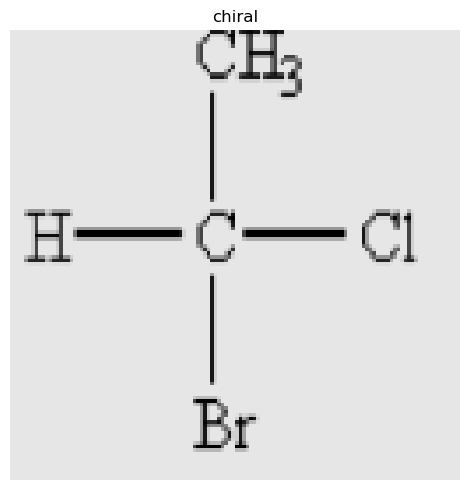

In [61]:
# Create a figure with one subplot (1 row, 1 column)
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))  # Adjust figsize as needed

# Choose which image and label to display (modify index if needed)
index_to_show = 0  # Change this to select a different image (0 or 1)

# Display the image on the subplot
ax.imshow(images[index_to_show])

# Get the class name and set the subplot title
label_index = int(labels[index_to_show])
class_name = class_names[label_index]
ax.set_title(f"{class_name}")

# Turn off axes for cleaner visualization (optional)
ax.axis('off')

# Adjust layout (optional, might not be needed with one subplot)
plt.tight_layout()

# Display the plot
plt.show()

# 2) Model

Reference code: [VASANT VOHRA](https://www.kaggle.com/code/vasantvohra1/transfer-learning-using-mobilenet)

There are three pre-trained models that are good to start off with for image classification:
* VGG16
* ResNet50
* Inception V3

However, my dataset is small. Therefore, I chose to use MobileNet as these models are used for larger datasets.

In [66]:
model = tf.keras.applications.MobileNet(
    input_shape=(128,128,3),
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights=None,
    input_tensor=None,
    pooling=None,
    classes=2,
    classifier_activation='softmax'
)